# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns

from geopy.geocoders import Nominatim

## 0.1 Loading Dataset

In [2]:
prices_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Price_AV_Itapema.csv', low_memory=False)
vivareal_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\VivaReal_Itapema.csv')
details_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Details_Data.csv')
hosts_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Hosts_ids_Itapema.csv')
mesh_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Mesh_Ids_Data_Itapema.csv')

## 0.2 Helper Functions

In [3]:
def get_city(x):
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(x[0])
    long = str(x[1])
    location = geolocator.reverse(lat+","+long)
    city = location.address.split(',')[2].strip()
    return city

def search_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
    return indices, li, ls

# 1.0 Data Description

In [4]:
details = details_raw.copy()
prices = prices_raw.copy()
mesh = mesh_raw.copy()
vivareal = vivareal_raw.copy()
hosts = hosts_raw.copy()

## 1.1 Looking Datasets

In [5]:
prices.head()

,airbnb_listing_id,date,price,price_string,minimum_stay,available,aquisition_date,av_for_checkin,av_for_checkout,index,bookable,ano,mes,dia
0,22258063,2022-11-27,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
1,22258063,2022-11-28,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
2,22258063,2022-11-29,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
3,22258063,2022-11-30,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
4,22258063,2022-12-01,500.0,R$500,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27


In [6]:
vivareal.head(3)

,listing_id,link_name,link_url,listing_type,listing_title,listing_desc,business_types,unit_type,unit_subtype,property_type,...,advertiser_id,advertiser_name,advertiser_phones,advertiser_whatsapp,advertiser_url,portal,aquisition_date,ano,mes,dia
0,2570403797,"Apartamento com 4 Quartos à venda, 187m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento com 4 dormitórios à venda, 187 m² ...",Situado em uma das melhores regiões da Meia Pr...,"[""SALE""]",APARTMENT,NaN,UNIT,...,39507409-01f8-3935-dc38-e0fea684b44a,Winner Brokers,"[""44984349088""]",4.498435e+10,https://www.vivareal.com.br/770696/winner-brok...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
1,2510420914,"Apartamento com 4 Quartos à venda, 253m²",https://www.vivareal.com.br/imovel/apartamento...,USED,Apartamento com 4 suítes 3 vagas em Itapema SC,"Apartamentos com 04 suítes, 03 vagas de garage...","[""SALE""]",APARTMENT,NaN,UNIT,...,cc5bc87d-b746-8b05-90f8-ef61f5020a69,FRANCA FERRAZ IMOBILIARIA,"[""4733630740"", ""47996961130""]",4.799696e+10,https://www.vivareal.com.br/116267/franca-ferr...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
2,2594648655,"Apartamento com 4 Quartos à venda, 210m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento à venda, Centro, Itapema, SC","Apartamento à Venda, 210m² por R$ 3.000.000. C...","[""SALE""]",APARTMENT,NaN,UNIT,...,ac9f84ae-1363-d2aa-1a6d-4adf1631539f,ARBO IMÓVEIS,"[""11999293012""]",1.199929e+10,https://www.vivareal.com.br/656548/arbo-imoveis/,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6


In [7]:
details.head(3)

,aquisition_date,url,ad_name,ad_description,ad_id,space,house_rules,amenities,safety_features,number_of_bathrooms,...,index,localized_star_rating,response_time_shown,response_rate_shown,guest_satisfaction_overall,picture_count,min_nights,ano,mes,dia
0,2022-07-11 07:21:51.61831,https://www.airbnb.com.br/rooms/27865733,Carambei 106,"Apartamento para 8 pessoas, lateral p praia. P...",27865733,Espaco TOP tipo hotel,"{""Não são permitidas festas ou eventos"",""Anima...","{Cabides,""Ferro de passar"",""Máquina de Lavar"",...",{},2.0,...,11043701.0,NaN,em até uma hora,100%,100.0,31.0,2.0,2022,7,11
1,2022-07-11 07:28:25.226756,https://www.airbnb.com.br/rooms/52200210,Apto aconchegante na rua + procurada da Meia P...,Sua família vai estar perto de tudo ao ficar n...,52200210,NaN,"{""Animais de estimação são permitidos""}","{""Máquina de Lavar"",TV,Ar-condicionado,Wi-Fi,""...",{},2.0,...,11082903.0,"5,0",em até uma hora,100%,100.0,43.0,2.0,2022,7,11
2,2022-07-18 07:19:40.053547,https://www.airbnb.com.br/rooms/53372578,Ótimo apartamento em Itapema,Ótimo para período de férias,53372578,"O Ap é bastante amplo, sala de star e jantar i...","{""Animais de estimação são permitidos""}","{""Local para guardar as roupas"",""Blackout nas ...","{""Extintor de incêndio""}",2.0,...,11300813.0,"3,0",NaN,NaN,60.0,11.0,7.0,2022,7,18


In [8]:
hosts.head(3)

,host_id,host_name,host_rating,n_reviews,n_reviews_from_host,n_listings,about_host,comments,aquisition_date,ano,mes,dia
0,160913639,Cayo,0.000,0,0,1,NaN,NaN,2022-12-05,2022,12,5
1,84162292,Ricardo,4.935,42,1,3,"Sou casado, tenho uma filha de 9 anos e um fil...","[""Obrigado Ricardo a estadia foi ótima muito ...",2022-12-05,2022,12,5
2,96045548,Eduardo,0.000,26,0,3,NaN,"[""Otimo"", ""muito bom local e muito claro nas e...",2022-12-05,2022,12,5


In [9]:
mesh.head()

,airbnb_listing_id,latitude,longitude,aquisition_date,ano,mes,dia
0,40560834,-27.091400,-48.612150,2022-12-01,2022,12,1
1,628340205412932131,-27.115776,-48.610996,2022-12-01,2022,12,1
2,39145712,-27.116170,-48.608290,2022-12-01,2022,12,1
3,40039627,-27.090200,-48.612450,2022-12-01,2022,12,1
4,40794806,-27.098660,-48.660700,2022-12-01,2022,12,1


## 1.2 Data Dimensions

In [10]:
print('prices')
print(f'Rows qtd: {prices.shape[0]}')
print(f'Columns qtd: {prices.shape[1]}\n')
print('vivareal')
print(f'Rows qtd: {vivareal.shape[0]}')
print(f'Columns qtd: {vivareal.shape[1]}\n')
print('details')
print(f'Rows qtd: {details.shape[0]}')
print(f'Columns qtd: {details.shape[1]}\n')
print('hosts')
print(f'Rows qtd: {hosts.shape[0]}')
print(f'Columns qtd: {hosts.shape[1]}\n')
print('mesh')
print(f'Rows qtd: {mesh.shape[0]}')
print(f'Columns qtd: {mesh.shape[1]}\n')

prices
Rows qtd: 43020080
Columns qtd: 14

vivareal
Rows qtd: 17547
Columns qtd: 42

details
Rows qtd: 32558
Columns qtd: 37

hosts
Rows qtd: 1357
Columns qtd: 12

mesh
Rows qtd: 2373
Columns qtd: 7



## 1.3 Datatypes

In [11]:
prices.dtypes

airbnb_listing_id      int64
date                  object
price                float64
price_string          object
minimum_stay           int64
available               bool
aquisition_date       object
av_for_checkin        object
av_for_checkout      float64
index                float64
bookable             float64
ano                    int64
mes                    int64
dia                    int64
dtype: object

In [12]:
hosts.dtypes

host_id                  int64
host_name               object
host_rating            float64
n_reviews                int64
n_reviews_from_host      int64
n_listings               int64
about_host              object
comments                object
aquisition_date         object
ano                      int64
mes                      int64
dia                      int64
dtype: object

In [13]:
details.dtypes

aquisition_date                object
url                            object
ad_name                        object
ad_description                 object
ad_id                           int64
space                          object
house_rules                    object
amenities                      object
safety_features                object
number_of_bathrooms           float64
number_of_bedrooms            float64
number_of_beds                float64
latitude                      float64
longitude                     float64
star_rating                   float64
additional_house_rules         object
owner                          object
check_in                       object
check_out                      object
number_of_guests                int64
is_superhost                     bool
number_of_reviews               int64
cohosts                        object
cleaning_fee                  float64
can_instant_book                 bool
owner_id                        int64
listing_type

In [14]:
vivareal.dtypes

listing_id                 int64
link_name                 object
link_url                  object
listing_type              object
listing_title             object
listing_desc              object
business_types            object
unit_type                 object
unit_subtype              object
property_type             object
usage_type                object
sale_price               float64
rental_price             float64
rental_period             object
yearly_iptu              float64
monthly_condo_fee        float64
amenities                 object
usable_area              float64
total_area               float64
bathrooms                float64
bedrooms                 float64
suites                   float64
parking_spaces           float64
address_country           object
address_state             object
address_city              object
address_neighborhood      object
address_street            object
address_street_number     object
address_complement       float64
address_zi

In [15]:
mesh.dtypes

airbnb_listing_id      int64
latitude             float64
longitude            float64
aquisition_date       object
ano                    int64
mes                    int64
dia                    int64
dtype: object

## 1.4 Check Na

In [16]:
round(prices.isna().sum() / prices['airbnb_listing_id'].count() * 100, 2)

airbnb_listing_id      0.00
date                   0.00
price                  0.01
price_string           0.00
minimum_stay           0.00
available              0.00
aquisition_date        0.00
av_for_checkin         0.09
av_for_checkout      100.00
index                100.00
bookable             100.00
ano                    0.00
mes                    0.00
dia                    0.00
dtype: float64

In [17]:
round(hosts.isna().sum() / hosts['host_id'].count() * 100, 2)

host_id                 0.00
host_name               0.00
host_rating             0.00
n_reviews               0.00
n_reviews_from_host     0.00
n_listings              0.00
about_host             76.05
comments               21.81
aquisition_date         0.00
ano                     0.00
mes                     0.00
dia                     0.00
dtype: float64

In [18]:
round(details.isna().sum() / details['aquisition_date'].count() * 100, 2)

aquisition_date                0.00
url                            0.00
ad_name                        0.00
ad_description                 5.75
ad_id                          0.00
space                         47.46
house_rules                    9.48
amenities                      0.00
safety_features                0.00
number_of_bathrooms            0.23
number_of_bedrooms             1.59
number_of_beds                 0.57
latitude                       0.00
longitude                      0.00
star_rating                   47.69
additional_house_rules        57.24
owner                          0.00
check_in                       8.31
check_out                     20.60
number_of_guests               0.00
is_superhost                   0.00
number_of_reviews              0.00
cohosts                       87.16
cleaning_fee                   0.00
can_instant_book               0.00
owner_id                       0.00
listing_type                   0.00
index                       

In [19]:
round(vivareal.isna().sum() / vivareal['listing_id'].count() * 100, 2)

listing_id                 0.00
link_name                  0.00
link_url                   0.00
listing_type               0.00
listing_title              0.06
listing_desc               0.54
business_types             0.00
unit_type                  0.00
unit_subtype              98.66
property_type              0.00
usage_type                 0.00
sale_price                 6.42
rental_price              93.35
rental_period             93.35
yearly_iptu               56.64
monthly_condo_fee         56.39
amenities                  0.00
usable_area                0.03
total_area                11.81
bathrooms                  0.23
bedrooms                   0.51
suites                     7.06
parking_spaces             4.47
address_country            0.00
address_state              0.00
address_city               0.00
address_neighborhood       5.37
address_street            38.38
address_street_number     41.03
address_complement       100.00
address_zipcode            0.10
location

In [20]:
round(mesh.isna().sum() / mesh['airbnb_listing_id'].count() * 100, 2)

airbnb_listing_id    0.0
latitude             0.0
longitude            0.0
aquisition_date      0.0
ano                  0.0
mes                  0.0
dia                  0.0
dtype: float64

## 1.5 Fillout Na

In [21]:
details = details[~details['number_of_bathrooms'].isna()]
details = details[~details['number_of_bedrooms'].isna()]
details = details[~details['number_of_beds'].isna()]

## 1.6 Rename Columns

In [22]:
prices.rename(columns={'airbnb_listing_id':'airbnb_id'}, inplace=True)
details.rename(columns={'ad_id':'airbnb_id'}, inplace=True)
mesh.rename(columns={'airbnb_listing_id':'airbnb_id'}, inplace=True)

## 1.7 Changing Datatipes

In [23]:
prices['date'] = pd.to_datetime(prices['date'])
prices = prices.sort_values('date')
prices['available'] = prices['available'].apply(lambda x: 1 if x==True else 0).astype(int)

details['number_of_bathrooms'] = details['number_of_bathrooms'].astype(int)
details['number_of_bedrooms'] = details['number_of_bedrooms'].astype(int)
details['number_of_beds'] = details['number_of_beds'].astype(int)

## 1.8 Data Cleaning

In [24]:
details['safety_features'] = details['safety_features'].apply(lambda x: re.sub('[^a-zA-Z0-9\n.çêó]', ' ', x))
details['safety_features'] = details['safety_features'].str.replace(' ', '')
details['safety_features'] = details['safety_features'].str.replace('Trancanaportadoquarto','')
details['safety_features'] = details['safety_features'].str.replace('u00ea', 'ê')
details['safety_features'] = details['safety_features'].str.replace('u00e7', 'ç')
details['safety_features'] = details['safety_features'].str.replace('u00f3', 'ó')

## 1.9 Integrating Dataframes

### 1.9.1 Merging

In [25]:
df = prices.loc[prices['available']==0, ['airbnb_id', 'date', 'price', 'aquisition_date']]
df = df.groupby(['airbnb_id', 'date']).agg({'price':'min', 'aquisition_date':'first'}).reset_index()
df.sort_values(['airbnb_id', 'date'], inplace=True)

temp = details[['airbnb_id', 'aquisition_date', 'safety_features', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests']]
temp = temp.groupby('airbnb_id').agg({'safety_features':'last', 'number_of_bathrooms':'mean', 'number_of_bedrooms':'mean', 'number_of_beds':'mean', 'number_of_guests':'mean'}).reset_index()
df = pd.merge(df, temp, on='airbnb_id', how='left')

### 1.9.2 Data Dimension

In [26]:
df.shape

(436867, 9)

In [27]:
df.shape

(436867, 9)

In [28]:
print(f'Quantity of rows: {df.shape[0]}')
print(f'Quantity of columns: {df.shape[1]}')

Quantity of rows: 436867
Quantity of columns: 9


In [29]:
len(df['airbnb_id'].drop_duplicates())

2274

### 1.9.3 Check Na

In [30]:
df.isna().sum()

airbnb_id                 0
date                      0
price                     0
aquisition_date           0
safety_features        9626
number_of_bathrooms    9626
number_of_bedrooms     9626
number_of_beds         9626
number_of_guests       9626
dtype: int64

### 1.9.4 Fillout Na

In [31]:
df.dropna(inplace=True)

## 1.10 Descriptive Statistical

In [32]:
num_attributes = ['price', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests']

### 1.10.1 Numerical Attributes

In [33]:
# Central tendency
ct1 = pd.DataFrame(df[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df[num_attributes].apply(min)).T
d3 = pd.DataFrame(df[num_attributes].apply(max)).T
d4 = pd.DataFrame(df[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
price,48.0,500900.0,500852.0,1192.299777,450.0,12553.794220,27.137698,822.101328
number_of_bathrooms,0.0,12.0,12.0,2.126669,2.0,0.876547,1.131108,3.981061
number_of_bedrooms,1.0,12.0,11.0,2.561916,3.0,0.875667,0.552405,2.688780
number_of_beds,0.0,50.0,50.0,3.691886,3.0,1.883445,2.377319,21.535771
number_of_guests,1.0,16.0,15.0,6.719911,6.0,2.488196,0.732132,1.846770


<AxesSubplot: >

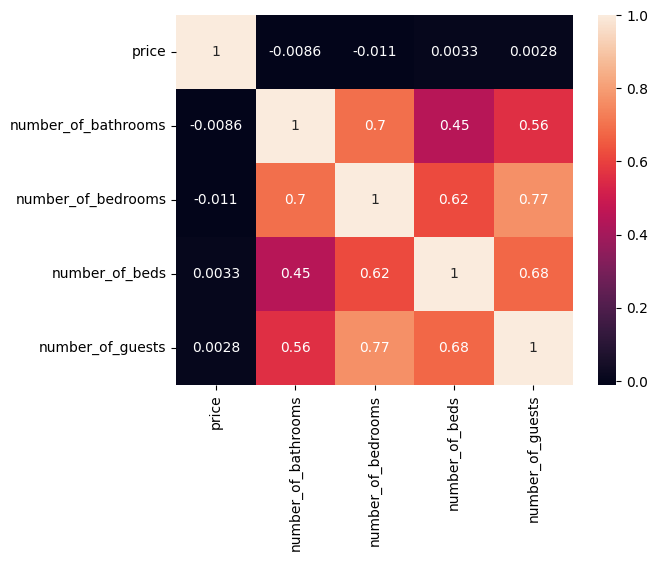

In [34]:
sns.heatmap(df[num_attributes].corr(), annot=True)

### 1.10.2 Categorical Attributes

# 2.0 Feature Engineering

In [35]:
# date range
max_date = prices['date'].max().strftime('%Y-%m-%d')
min_date = prices['date'].min().strftime('%Y-%m-%d')
min_date = pd.to_datetime(min_date)
max_date = pd.to_datetime(max_date)
date_delta = (max_date - min_date).days

# data reference
df_ref = df[['airbnb_id']].drop_duplicates(ignore_index=True)

# lifetime value
temp = df.groupby('airbnb_id').agg({'price':'sum'}).reset_index().rename(columns=({'price':'gross_revenue'}))
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# recency
temp = df.groupby('airbnb_id').agg({'date':'max'}).reset_index().rename(columns=({'date':'last_revenue'}))
temp['recency'] = (max_date - temp['last_revenue']).dt.days
temp.drop(['last_revenue'], axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# frequency
temp = df.groupby('airbnb_id').agg({'price':'count'}).reset_index().rename(columns=({'price':'quantity_sell'}))
temp['frequency'] = date_delta / temp['quantity_sell']
temp.drop('quantity_sell', axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# 3.0 Exploratory Data Analysis

# 4.0 Data Filtering

## 4.1 Columns Filtering

## 4.2 Rows Filtering

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Hyperparameter Fine-tuning

# 8.0 Clustering Model Training